### Import Package

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
import os
import random
from os.path import join
from os import listdir
import glob
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as utils
import torchvision.datasets as dsets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import time
from skimage.restoration import denoise_nl_means
from scipy.signal import medfilt2d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage import io
from torchvision.transforms.functional import to_pil_image

import warnings
warnings.filterwarnings(action='ignore')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/tmp/ipykernel_3787216/1881073022.py:26: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_3787216/1881073022.py:27: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


In [3]:
# Empty GPU 
torch.cuda.empty_cache()

In [4]:
# Set random seed for reproductibility 
manualSeed = 303
print("Random seed:",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 303


### Define parameter

In [5]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
device = 'cuda'
print("Use : ", DEVICE)

Use :  cuda


### Define Dataset

In [6]:
path = '/home/user303/GAN/COVID-19_Radiography_Dataset/COVID/images'
image_paths = glob.glob(path + '/*.png')
image_paths = sorted(image_paths)

img_size = 128
batch_size = 32
transform=transforms.Compose([
                               transforms.ToPILImage(),
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                           ])

In [7]:
import cv2
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        image_path = self.paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
        
        if self.transform:
            image_tensor = self.transform(image)
            
        return image_tensor
    
train_dataset = ImageDataset(image_paths[:round(len(image_paths)*0.8)], transform)
test_dataset = ImageDataset(image_paths[round(len(image_paths)*0.8):], transform)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  drop_last=True, num_workers=1)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### Define Noise

In [9]:
import numpy as np
import os
import cv2
def add_noise(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        image = np.array(image)
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = torch.Tensor(noisy)
        return noisy
    
    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        noisy = torch.Tensor(noisy)
        return noisy

In [10]:
batch_size = 32
img_size = 128
num_epochs = 10 #Change
lr = 0.0002
beta1 = 0.5
img_shape = (1, img_size, img_size)
beta1 = 0.5

### Define Model

### 1) CDAE

In [11]:
class encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(encoder, self).__init__()
        self.mpconv = nn.Sequential( 
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2))
    def forward(self, x):
        x = self.mpconv(x)
        return x

In [12]:
class decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(decoder, self).__init__()
        self.mpconv = nn.Sequential( 
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2))
    def forward(self, x):
        x = self.mpconv(x)
        return x

In [13]:
class CDAE(nn.Module):
    def __init__(self):
        super(CDAE, self).__init__()
        ## encoder
        self.enc1 = encoder(1,16)
        self.enc2 = encoder(16,32)
        self.enc3 = nn.Conv2d(32, 64, 3, padding=1)
        
        ## decoder
        self.deconv1 = decoder(64, 32)
        self.deconv2 = decoder(32, 16)
        self.deconv3 = nn.Conv2d(16, 1, 3, padding=1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.enc1(x)
        x1 = self.enc2(x)
        x2 = self.enc3(x1)
        x3 = self.deconv1(x2)
        x4 = self.deconv2(x3)
        x5 = self.deconv3(x4)
        x6 = self.out(x5)
        return x6

In [14]:
x = torch.randn(16,1,128,128,device=device)
model = CDAE().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 1, 128, 128])


In [15]:
net_CDAE = model.to(device)

### 2) DnCNN

In [16]:
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_features=64):
        super(DnCNN, self).__init__()
        layers = [nn.Sequential(nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(num_features),
                                        nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 1, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        return y - residual

In [17]:
x = torch.randn(16,1,128,128,device=device)
model = DnCNN().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 1, 128, 128])


### 3) U-DCGAN

In [18]:
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch, conv=conv)
    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            DoubleConv(in_ch, out_ch, conv=conv)
         )
    def forward(self, x):
        x = self.mpconv(x)
#         print("Down conv output: ", x.shape)
        return x

In [20]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, conv=conv)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
#         print("Up conv output: ", x.shape)
        return x

In [21]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, conv=nn.Conv2d):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.LeakyReLU(0.2, inplace=True)]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        self.outc = nn.Sigmoid()
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        x1 = self.outc(x)
        return x1

In [23]:
x = torch.randn(16,1,128,128,device=device)
model = Generator().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 1, 128, 128])


In [24]:
nc=1
ndf = 64
ngf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
netD = Discriminator().to(device)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net_CDAE.parameters(), lr=lr)
is_cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

### Train

In [21]:
def sample_images(batches_done):
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs["B"].type(Tensor))
    real_B = Variable(imgs["A"].type(Tensor))
    fake_B = generator(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, "images/%s/%s.png" % (opt.dataset_name, batches_done), nrow=5, normalize=True)

In [22]:
def PSNR(img1, img2, min_value=0, max_value=1):

    if type(img1) == torch.Tensor:
        mse = torch.mean((img1 - img2) ** 2)
    else:
        mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * math.log10((PIXEL_MAX ** 2) / mse)

In [26]:
img_list = []
img_list2 = []
losses = []
p = []
print("Starting Training Loop...")
for epoch in range(num_epochs):
    psnr = 0
    for x in dataloader:
        with torch.autograd.set_detect_anomaly(True):
            real_a = add_noise("gauss",x).to(device)
            real_b = x.to(device)
            b_size = real_a.size(0)

            net_CDAE.zero_grad()
            restore_b = net_CDAE(real_a.float()) # Restore Image

            loss = criterion(restore_b, real_b)
            # 변화도를 계산합니다
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            train_psnr = PSNR(restore_b, real_b)
            psnr += train_psnr/len(dataloader)
    p.append(psnr)
      
    print('[%d/%d]\tloss: %.6f\tpsnr: %.6f'% (epoch,num_epochs, loss.item(), psnr))
     
    losses.append(loss.item())
    if (epoch % 5 == 0) or ((epoch == num_epochs-1)):
        with torch.no_grad():
            restore = net_CDAE(real_a.float()).detach().cpu()
        img_list2.append(restore)    
        img_list.append(utils.make_grid(restore, padding=2, normalize=True))

Starting Training Loop...
[0/10]	loss: 0.001359	psnr: 28.300277
[1/10]	loss: 0.001211	psnr: 28.464640
[2/10]	loss: 0.001444	psnr: 28.607388
[3/10]	loss: 0.001227	psnr: 28.722802
[4/10]	loss: 0.001150	psnr: 28.810783
[5/10]	loss: 0.001548	psnr: 28.897843
[6/10]	loss: 0.001251	psnr: 28.957971
[7/10]	loss: 0.001338	psnr: 29.018545
[8/10]	loss: 0.001330	psnr: 29.083217
[9/10]	loss: 0.001191	psnr: 29.128915


In [59]:
# U-DCGAN 학습 코드
# img_list = []
# img_list2 = []
# G_losses = []
# D_losses = []
# p = []
# iters = 0
# start_time = time.time()
# print("Starting Training Loop...")
# for epoch in range(num_epochs):
#     psnr = 0

#     for x in dataloader:
#         with torch.autograd.set_detect_anomaly(True):
#             real_a = add_noise("gauss",x).to(device)
#             real_b = x.to(device)
#             b_size = real_a.size(0)
#             real_labels = torch.full((b_size,), real_label, device=device,dtype=torch.float)
#             fake_labels = torch.full((b_size,), fake_label, device=device,dtype=torch.float)


#             netG.zero_grad()
#             fake_b = netG(real_a.float()) # 가짜 이미지 생성
#             output = netD(fake_b) # 가짜 이미지 식별
            

#             errG = loss_func_gan(output.squeeze(), real_labels)
#             pixel_loss = loss_func_pix(fake_b, real_b)
#             g_loss = errG + lambda_pixel * pixel_loss
#             g_loss.backward()
#             D_G_z2 = output.mean().item()
#             optimizerG.step()
            

#             netD.zero_grad()
#             out_dis = netD(real_b) # 진짜 이미지 식별
#             errD_real = loss_func_gan(out_dis.squeeze(),real_labels)
#             #errD_real.backward(retain_graph=True)
#             D_x = out_dis.mean().item()


            
#             out_dis = netD(fake_b.detach()) # 가짜 이미지 식별
#             errD_fake = loss_func_gan(out_dis.squeeze(),fake_labels)
#             D_G_z1 = out_dis.mean().item()
#             errD = errD_real + errD_fake
#             errD.backward()
#             optimizerD.step()
            
#             train_psnr = PSNR(fake_b, real_b)
#             psnr += train_psnr/len(dataloader)
#     p.append(psnr)
      
#     print('[%d/%d]\tLoss_D: %.6f\tLoss_G: %.6f\tD(x): %.6f\tD(G(z)): %.6f / %.6f\tpixel_loss: %.6f\terrG: %.6f\tpsnr: %.6f\ttime: %.6f'
#             % (epoch, num_epochs,errD.item(), g_loss.item(), D_x, D_G_z1, D_G_z2, pixel_loss.item(), errG.item(), psnr, (time.time()-start_time)))
     
#     G_losses.append(errG.item())
#     D_losses.append(errD.item())

#     if (epoch % 5 == 0) or ((epoch == num_epochs-1)):
#         with torch.no_grad():
#             fake = netG(real_a.float()).detach().cpu()
#         img_list2.append(fake)    
#         img_list.append(utils.make_grid(fake, padding=2, normalize=True))

### Visualization

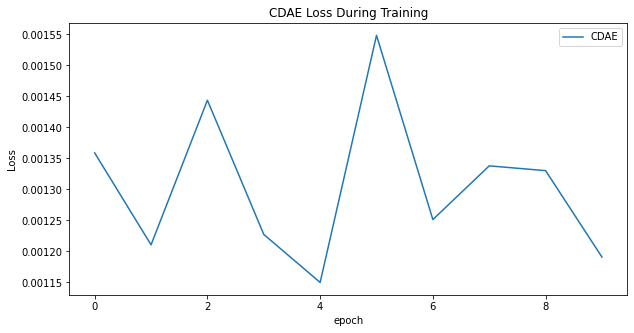

In [27]:
plt.figure(figsize=(10,5))
plt.title("CDAE Loss During Training")
plt.plot(losses,label="CDAE")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

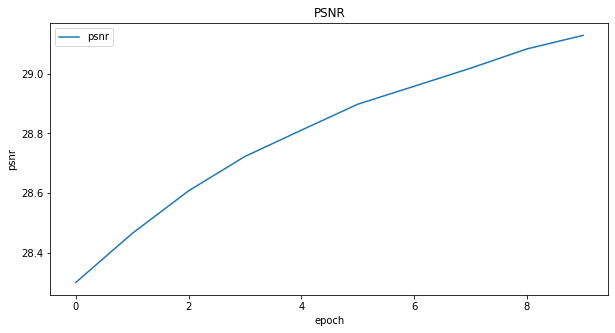

In [28]:
plt.figure(figsize=(10,5))
plt.title("PSNR")
plt.plot(p,label="psnr")
plt.xlabel("epoch")
plt.ylabel("psnr")
plt.legend()
plt.show()

### Test data Visualization

In [26]:
# Store Weights
# path2models = './md/'
# os.makedirs(path2models, exist_ok=True)
# path2weights_cdae = os.path.join(path2models, 'cdae_가우시안.pt')

#torch.save(net_CDAE.state_dict(), path2weights_cdae)

In [30]:
# Load Weights
path2weights_cdae = './md/cdae_가우시안.pt'
weights = torch.load(path2weights_cdae)
net_CDAE.load_state_dict(weights)

<All keys matched successfully>

In [31]:
# evaluation model
net_CDAE.eval()
f= []
r = []
n = []
with torch.no_grad():
    for x in test_loader:
        real_test_a = add_noise("gauss",x).to(device)
        n.append(real_test_a)
        fake_imgs = net_CDAE(real_test_a.float()).cpu()
        f.append(fake_imgs)
        real_imgs = x
        r.append(real_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


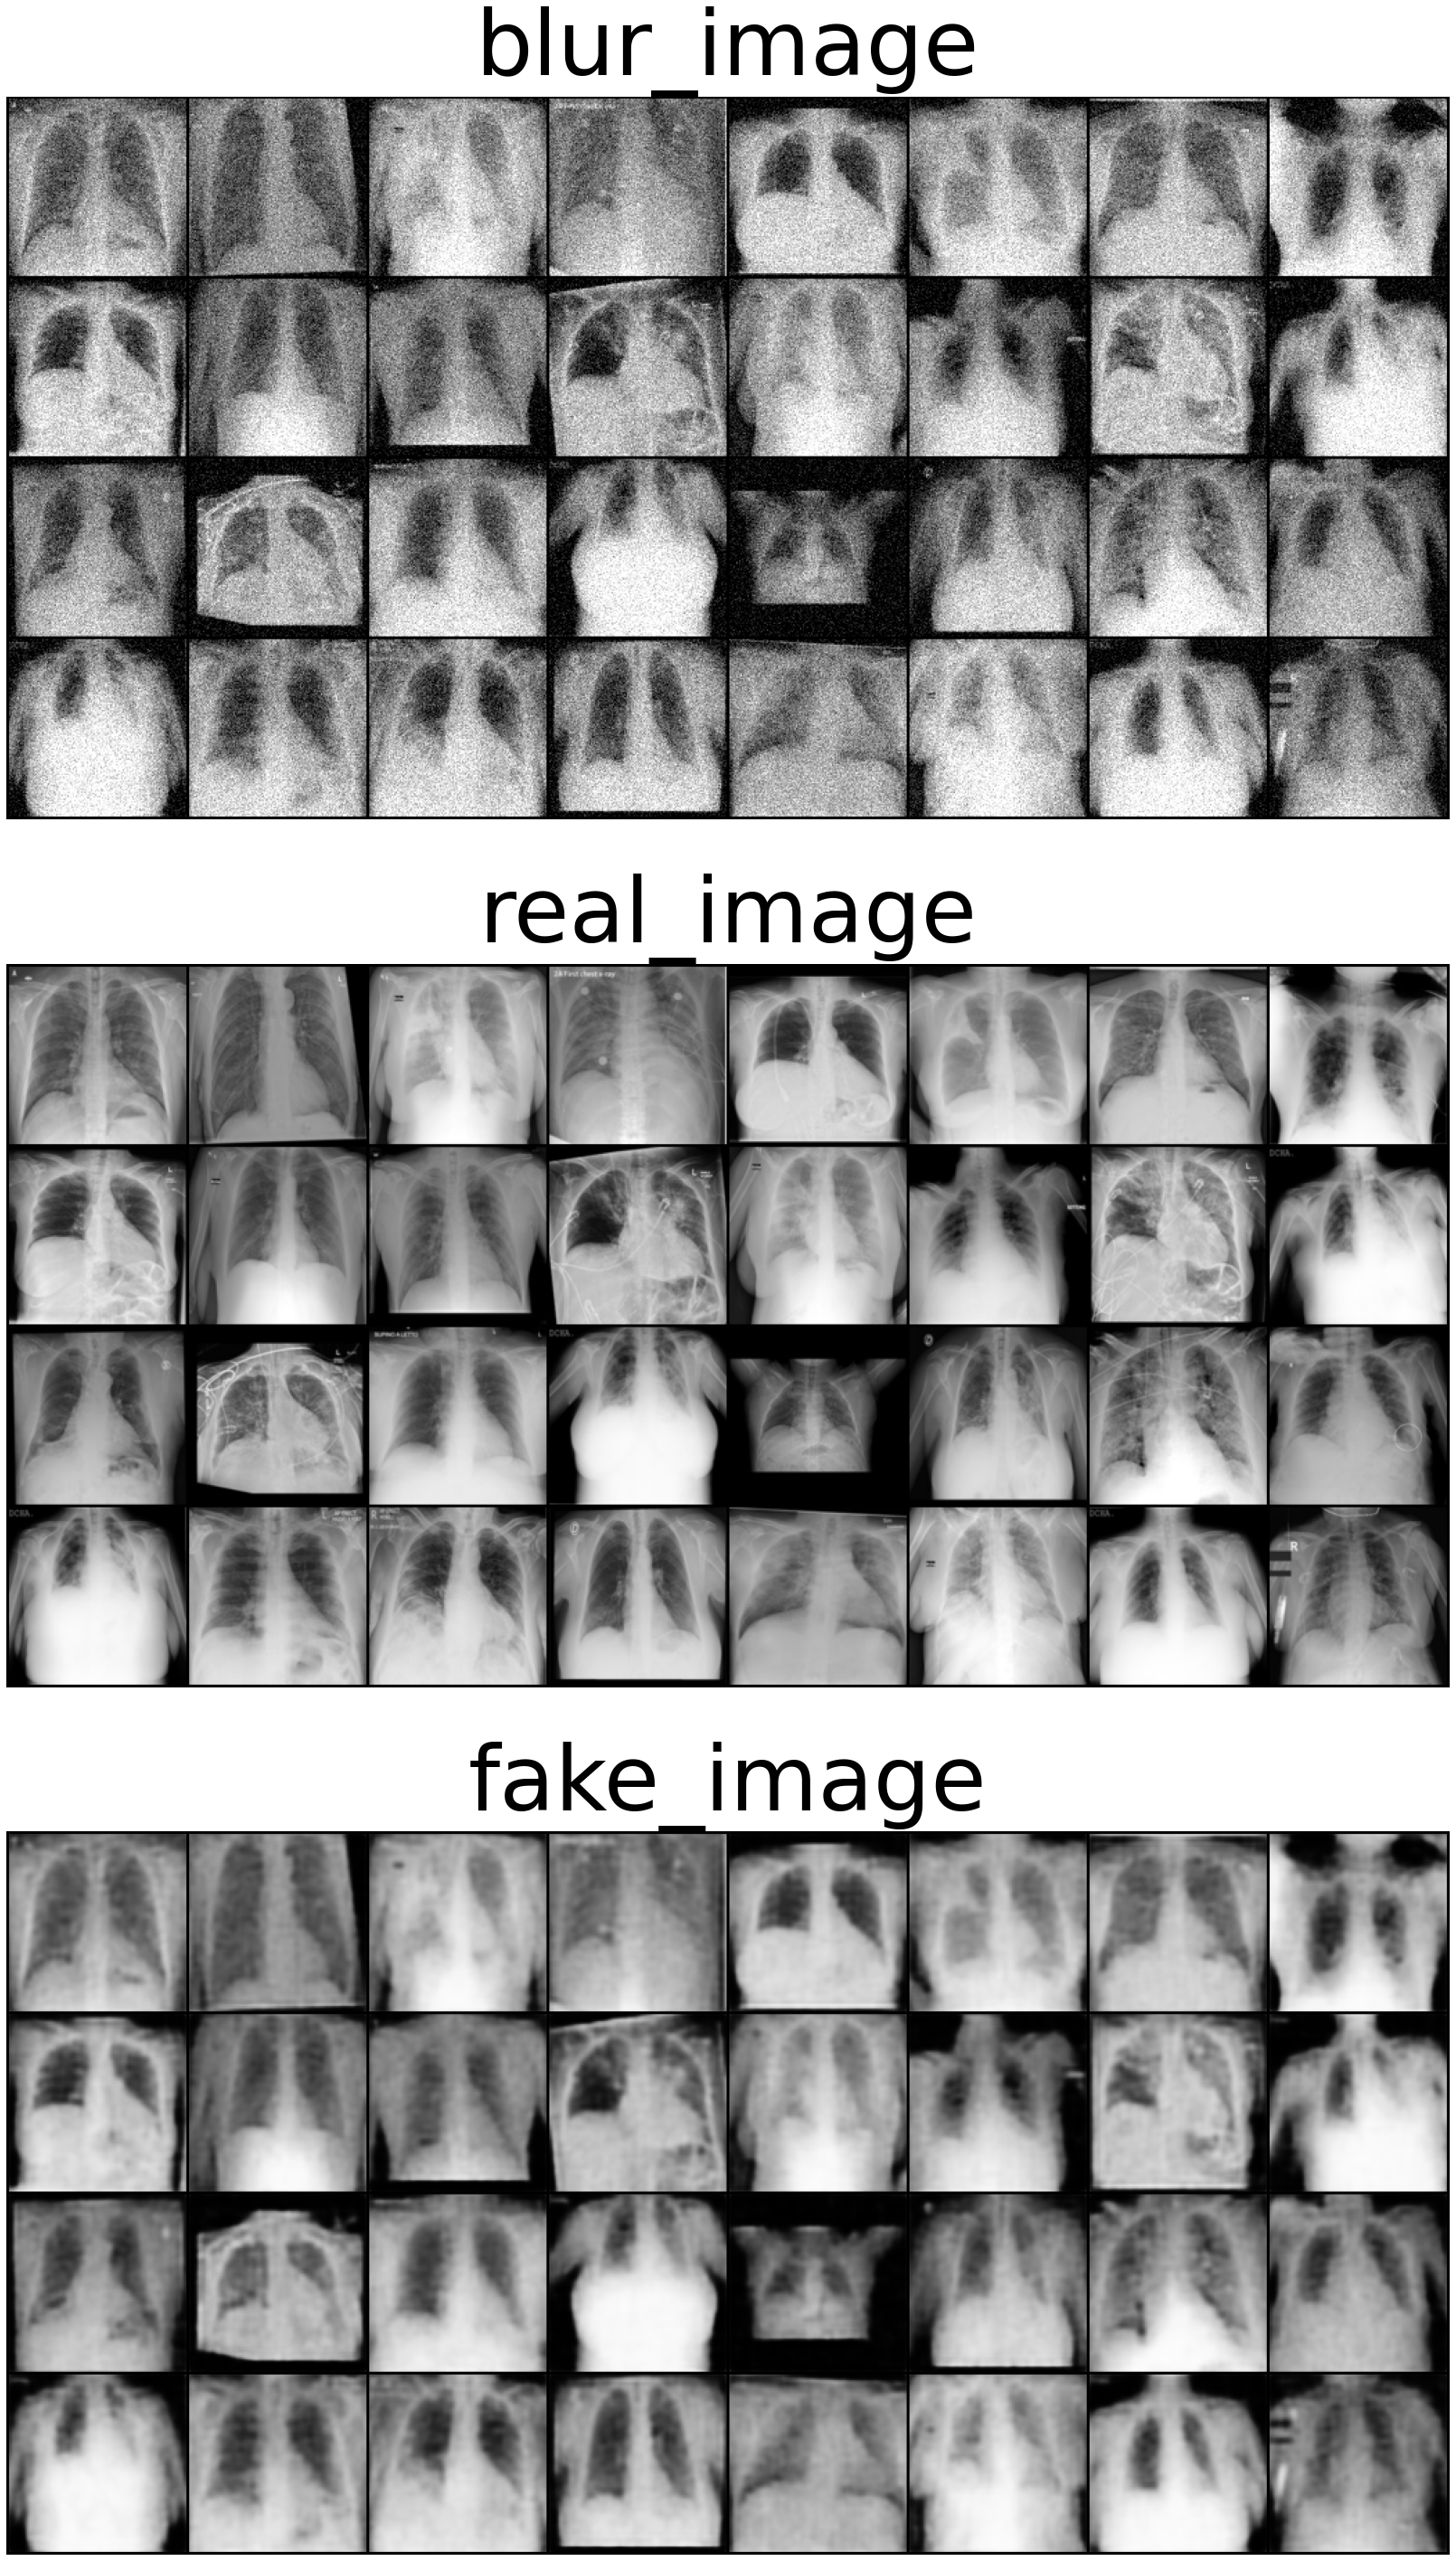

In [33]:
# 가짜 이미지 시각화
plt.figure(figsize=(50,50))

for ii in range(0,8,4):
    plt.subplot(3,1,1)
    plt.title('blur_image',fontsize= 100)
    plt.imshow(np.transpose(utils.make_grid(n[ii]).cpu(),(1,2,0)))
    plt.axis('off')
    plt.subplot(3,1,2)
    plt.title('real_image',fontsize= 100)
    plt.imshow(np.transpose(utils.make_grid(r[ii]).cpu(),(1,2,0)))
    plt.axis('off')
    plt.subplot(3,1,3)
    plt.title('fake_image',fontsize= 100)
    plt.imshow(np.transpose(utils.make_grid(f[ii]).cpu(),(1,2,0)))
    plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

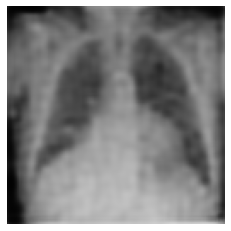

In [34]:
plt.imshow(np.transpose(utils.make_grid(f[0][7]).cpu(),(1,2,0)))
plt.axis('off')

In [35]:
result = []
for i in range(len(r)):
    for j in range(22):
        result.append(PSNR(r[i][j], f[i][j]))
print(np.mean(result))

31.20593772023886


### MAE

In [37]:
mae_loss = nn.L1Loss()

mae = []


for i in range(len(r)):
    for j in range(22):
        mae.append(mae_loss(r[i][j], f[i][j]))
    
print("MAE")
print(np.mean(mae))

MAE
0.020040937


### SSIM

In [41]:
from skimage.metrics import structural_similarity as ssim 
result_s = []
for i in range(len(r)):
    for j in range(22):
        c = r[i][j].squeeze()
        d =  f[i][j].squeeze()
        score = ssim(np.array(c), np.array(d))
        result_s.append(score)
print(np.mean(result_s))

0.9328068713870935
